In [2]:
# Import necessary libraries
from pathlib import Path
import os 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## UNSW-NB15

In [5]:
# Datapath
current_path = Path.cwd()
parent_path = current_path.parents[0]
#parent_path = parent_path.parents[0]
data_path = parent_path / "abnormal_detection_data"
train_file = "unsw_nb15_train_nocat.csv"
test_file = "unsw_nb15_test_nocat.csv"
file_path_train = data_path / "train" / train_file
file_path_test = data_path / "test" / test_file

file_path_train, file_path_test

(PosixPath('/share/home/lole4878/workspace/fedpca/FedPG_Abnormal_Detection/abnormal_detection_data/train/unsw_nb15_train_nocat.csv'),
 PosixPath('/share/home/lole4878/workspace/fedpca/FedPG_Abnormal_Detection/abnormal_detection_data/test/unsw_nb15_test_nocat.csv'))

In [6]:
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

df_train.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,2,1,40,0,0,0,2,39,0,Normal


In [8]:
df_test['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [9]:
# Type of attack in train and test
df_train["attack_cat"].unique(), df_test["attack_cat"].unique()

(array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
        'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
       dtype=object),
 array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
        'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
       dtype=object))

In [10]:
# Get all normal data for training
train_normal = df_train[df_train["attack_cat"] == "Normal"]
train_normal.shape

(56000, 40)

In [11]:
# Clone test data for testing without affecting to original one
test_data = df_test.copy(deep=True)
test_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,1,1,3,0,0,0,1,3,0,Normal
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal


In [12]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):

  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [13]:
df_test_normal = test_data[test_data["attack_cat"]=="Normal"]
df_test_abnormal = test_data[test_data["attack_cat"]!="Normal"]
df_test_normal["attack_cat"].unique(), df_test_abnormal["attack_cat"].unique()

(array(['Normal'], dtype=object),
 array(['Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis',
        'Fuzzers', 'Worms', 'Shellcode', 'Generic'], dtype=object))

In [14]:
df_train = train_normal.drop("attack_cat", axis=1)
df_test_normal = df_test_normal.drop("attack_cat", axis=1)
df_test_abnormal = df_test_abnormal.drop('attack_cat', axis=1)

In [15]:
df_test_normal = df_test_normal[:20000]
df_test_abnormal = df_test_abnormal

In [16]:
df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns

In [17]:
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train)
df_test = pd.DataFrame(scaler.transform(df_test))
df_test.columns = df_test_abnormal.columns

In [18]:
df_train.shape, df_test.shape, df_test_normal.shape, df_test_abnormal.shape

((56000, 39), (65332, 39), (20000, 39), (45332, 39))

In [15]:
# df_train.to_csv("unswnb15_train_normal.csv")
# df_test_normal.to_csv("unswnb15_test_normal.csv")
# df_test_abnormal.to_csv("unswnb15_test_abnormal.csv")

### Centralized PCA

In [22]:
from sklearn.decomposition import PCA
def perform_pca(df_train, df_test):
  pca = PCA(0.99)
  pca.fit(scaler.transform(df_train))

  # we don't use built-in fit_transform() since we fit on train and transform over test. In fact, we can fit(df_train) and transform(df_test) as well.
  # source code: https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/decomposition/_pca.py#L411
  # df_test_PCA_manual = (df_test-scaler.mean_).dot(pca.components_.T)
  # df_test_PCA_inverse_manual = df_test_PCA_manual.dot(pca.components_) + scaler.mean_
  df_test_PCA = pca.transform(df_test)
  df_test_PCA_inverse = pca.inverse_transform(df_test_PCA)
  # debug: passed
  # print(np.allclose(df_test_PCA, df_test_PCA_manual))
  # print(np.allclose(df_test_PCA_inverse, df_test_PCA_inverse_manual))
  df_test_PCA = pd.DataFrame(df_test_PCA)
  df_test_PCA_inverse = pd.DataFrame(df_test_PCA_inverse)
  print(pca.components_.shape)
  return df_test_PCA, df_test_PCA_inverse

In [23]:
# Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train)
df_test_PCA, df_test_PCA_inverse = perform_pca(df_train, df_test)

abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
df_gt_score_PCA['anomalyScore'] = abnormal_score

(16, 39)


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

def results_analysis(df_gt_score, threshold, log=0):
  df_gt_pred = pd.DataFrame()
  df_gt_pred['ground_true'] = df_gt_score['ground_true']
  index = df_gt_score['anomalyScore'] > threshold
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN) # False positive rate (FPR); False Alarm = FP/N

  if log:
    # print(classification_report(df_gt_pred['ground_true'], df_gt_pred['prediction']))
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr

In [25]:
lst_rho = np.linspace(0,0.00002,100)
print(lst_rho)
df = pd.DataFrame(np.zeros((len(lst_rho),6)))
df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
for i, rho in enumerate(lst_rho):
  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=rho, log=0)
  df.iloc[i,0] = rho
  df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

[0.00000000e+00 2.02020202e-07 4.04040404e-07 6.06060606e-07
 8.08080808e-07 1.01010101e-06 1.21212121e-06 1.41414141e-06
 1.61616162e-06 1.81818182e-06 2.02020202e-06 2.22222222e-06
 2.42424242e-06 2.62626263e-06 2.82828283e-06 3.03030303e-06
 3.23232323e-06 3.43434343e-06 3.63636364e-06 3.83838384e-06
 4.04040404e-06 4.24242424e-06 4.44444444e-06 4.64646465e-06
 4.84848485e-06 5.05050505e-06 5.25252525e-06 5.45454545e-06
 5.65656566e-06 5.85858586e-06 6.06060606e-06 6.26262626e-06
 6.46464646e-06 6.66666667e-06 6.86868687e-06 7.07070707e-06
 7.27272727e-06 7.47474747e-06 7.67676768e-06 7.87878788e-06
 8.08080808e-06 8.28282828e-06 8.48484848e-06 8.68686869e-06
 8.88888889e-06 9.09090909e-06 9.29292929e-06 9.49494949e-06
 9.69696970e-06 9.89898990e-06 1.01010101e-05 1.03030303e-05
 1.05050505e-05 1.07070707e-05 1.09090909e-05 1.11111111e-05
 1.13131313e-05 1.15151515e-05 1.17171717e-05 1.19191919e-05
 1.21212121e-05 1.23232323e-05 1.25252525e-05 1.27272727e-05
 1.29292929e-05 1.313131

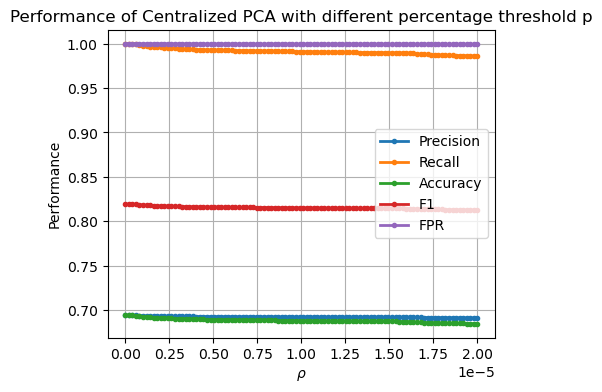

In [26]:
plt.figure(figsize=(5, 4));
plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
plt.xlabel(r'$\rho$')
plt.ylabel('Performance')
# plt.xticks(xticks)
# plt.legend(loc = 'lower right')
plt.legend()
plt.grid()
plt.title("Performance of Centralized PCA with different percentage threshold p")
# plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
plt.show()

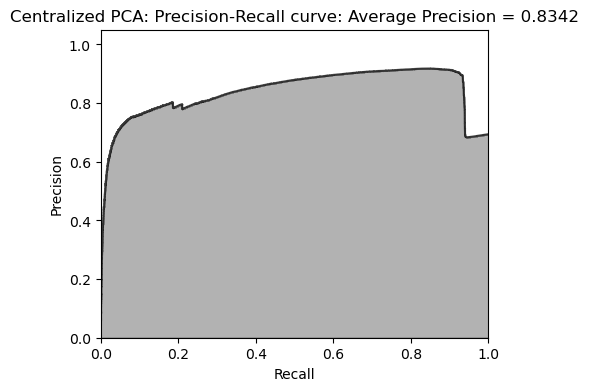

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])
average_precision = average_precision_score(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])

plt.figure(figsize=(5, 4));
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Centralized PCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
plt.show()

In [28]:
precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=0.000001, log=1)

Precision: 69.3455%
Recall: 99.7993%
Accuracy score: 69.2494%
F1 score: 81.8308%
False alarm: 99.995%


### Standalone  PCA

In [32]:
df_test_raw = df_test.copy()
df_normal_train = df_train.copy()
num_users = 100
fraction  = int(df_normal_train.shape[0] / num_users)
fraction, df_test_raw.shape

(560, (65332, 39))

In [33]:
df_normal_train = df_normal_train.sort_values(by=['ct_srv_src'])
df_normal_train = df_normal_train.reset_index(drop=True)
df_normal_train

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,1,1,1,1,0,0,0,1,1,0
1,1.076050,14,18,1684,10168,28.809069,31,29,1.162771e+04,71401.882810,...,4,1,1,1,0,0,1,2,3,0
2,1.005373,12,18,1580,10168,28.845016,31,29,1.153005e+04,76421.390630,...,3,1,1,1,0,0,1,1,2,0
3,0.001097,2,2,130,162,2734.731157,31,29,4.740201e+05,590701.937500,...,7,1,1,2,0,0,0,6,2,0
4,2.415148,52,54,2934,3742,43.475596,31,29,9.533163e+03,12166.541990,...,2,1,1,4,1,1,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,0.000010,2,0,1422,0,100000.002500,254,0,5.688000e+08,0.000000,...,9,9,1,63,0,0,0,9,62,0
55996,0.000009,2,0,452,0,111111.107200,254,0,2.008889e+08,0.000000,...,4,4,1,63,0,0,0,4,62,0
55997,0.000011,2,0,2158,0,90909.090200,254,0,7.847273e+08,0.000000,...,4,4,1,63,0,0,0,4,62,0
55998,0.000010,2,0,570,0,100000.002500,254,0,2.280000e+08,0.000000,...,6,6,1,63,0,0,0,6,62,0


In [36]:
#df_normal_train = df_train.copy()
avg_acc = 0
for i in range(100):
  df_train_stdPCA = df_normal_train[fraction*i:fraction*(i+1)].copy()
  df_train_client = df_train_stdPCA.copy()
  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train_client)
  df_test = pd.DataFrame(scaler.transform(df_test_raw))
  df_test.columns = df_test_abnormal.columns
  # Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train_client)
  _, df_test_PCA_inverse = perform_pca(df_train_client, df_test)

  abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

  df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
  df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score_PCA['anomalyScore'] = abnormal_score
  # plot_results(df_gt_score_PCA)

  # choose the right threshold
  lst_p = np.arange(0.4,0.8,0.001) # Among test, ratio of normal/abnormal = 0.75
  lst_rho = np.quantile(df_gt_score_PCA.anomalyScore, lst_p)
  optimal_p = 0.5
  optimal_rho = lst_rho[abs(lst_p - optimal_p)<1e-4][0]

  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=optimal_rho, log=1)
  avg_acc += accuracy_score
print(f"Average Accuracy: {100.0*avg_acc/100}")

/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 92.5628%
Recall: 66.688%
Accuracy score: 73.1678%
F1 score: 77.5233%
False alarm: 12.145%
(19, 39)
Precision: 92.5637%
Recall: 66.6968%
Accuracy score: 73.1739%
F1 score: 77.5296%
False alarm: 12.145%
(21, 39)
Precision: 92.841%
Recall: 66.8843%
Accuracy score: 73.4433%
F1 score: 77.7536%
False alarm: 11.69%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 91.7762%
Recall: 66.099%
Accuracy score: 72.3673%
F1 score: 76.8495%
False alarm: 13.425%
(20, 39)
Precision: 92.5502%
Recall: 66.6483%
Accuracy score: 73.1357%
F1 score: 77.4921%
False alarm: 12.16%
(24, 39)
Precision: 91.3734%
Recall: 65.8211%
Accuracy score: 71.9724%
F1 score: 76.5204%
False alarm: 14.085%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.4834%
Recall: 55.0781%
Accuracy score: 57.0792%
F1 score: 64.0394%
False alarm: 38.385%
(25, 39)
Precision: 76.2712%
Recall: 54.959%
Accuracy score: 56.8833%
F1 score: 63.8845%
False alarm: 38.755%
(25, 39)
Precision: 77.4597%
Recall: 55.8171%
Accuracy score: 58.0726%
F1 score: 64.8812%
False alarm: 36.815%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(20, 39)
Precision: 90.8572%
Recall: 65.349%
Accuracy score: 71.3938%
F1 score: 76.0204%
False alarm: 14.905%
(22, 39)
Precision: 92.7388%
Recall: 66.8005%
Accuracy score: 73.3347%
F1 score: 77.6611%
False alarm: 11.855%
(22, 39)
Precision: 92.5544%
Recall: 66.6615%
Accuracy score: 73.1464%
F1 score: 77.5025%
False alarm: 12.155%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 91.7646%
Recall: 66.1211%
Accuracy score: 72.3749%
F1 score: 76.8604%
False alarm: 13.45%
(24, 39)
Precision: 92.5553%
Recall: 66.6703%
Accuracy score: 73.1525%
F1 score: 77.5088%
False alarm: 12.155%
(22, 39)
Precision: 92.5383%
Recall: 66.6703%
Accuracy score: 73.1433%
F1 score: 77.5028%
False alarm: 12.185%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.2708%
Recall: 54.9435%
Accuracy score: 56.8757%
F1 score: 63.8739%
False alarm: 38.745%
(25, 39)
Precision: 76.2611%
Recall: 54.9281%
Accuracy score: 56.8619%
F1 score: 63.8601%
False alarm: 38.755%
(21, 39)
Precision: 76.2752%
Recall: 54.9568%
Accuracy score: 56.8848%
F1 score: 63.8844%
False alarm: 38.745%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 91.7573%
Recall: 66.0814%
Accuracy score: 72.3459%
F1 score: 76.8309%
False alarm: 13.455%
(21, 39)
Precision: 90.5808%
Recall: 65.2321%
Accuracy score: 71.1688%
F1 score: 75.8445%
False alarm: 15.375%
(20, 39)
Precision: 92.6037%
Recall: 66.7277%
Accuracy score: 73.2153%
F1 score: 77.5645%
False alarm: 12.08%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 76.0202%
Recall: 54.7781%
Accuracy score: 56.6323%
F1 score: 63.6742%
False alarm: 39.165%
(25, 39)
Precision: 92.5612%
Recall: 66.6725%
Accuracy score: 73.1571%
F1 score: 77.5123%
False alarm: 12.145%
(23, 39)
Precision: 77.4659%
Recall: 55.8215%
Accuracy score: 58.0787%
F1 score: 64.8863%
False alarm: 36.805%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(25, 39)
Precision: 78.2472%
Recall: 56.3465%
Accuracy score: 58.841%
F1 score: 65.515%
False alarm: 35.505%
(24, 39)
Precision: 92.5538%
Recall: 66.6836%
Accuracy score: 73.1602%
F1 score: 77.5172%
False alarm: 12.16%
(22, 39)
Precision: 82.0915%
Recall: 59.1547%
Accuracy score: 62.7043%
F1 score: 68.7607%
False alarm: 29.25%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 91.348%
Recall: 65.8188%
Accuracy score: 71.9571%
F1 score: 76.51%
False alarm: 14.13%
(26, 39)
Precision: 91.3607%
Recall: 65.8078%
Accuracy score: 71.9571%
F1 score: 76.507%
False alarm: 14.105%
(23, 39)
Precision: 77.0668%
Recall: 55.5016%
Accuracy score: 57.6639%
F1 score: 64.5302%
False alarm: 37.435%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 91.6914%
Recall: 66.0703%
Accuracy score: 72.303%
F1 score: 76.8004%
False alarm: 13.57%
(22, 39)
Precision: 75.9864%
Recall: 54.7185%
Accuracy score: 56.5818%
F1 score: 63.6221%
False alarm: 39.195%
(23, 39)
Precision: 92.5696%
Recall: 66.699%
Accuracy score: 73.1785%
F1 score: 77.5332%
False alarm: 12.135%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.2835%
Recall: 54.9678%
Accuracy score: 56.8955%
F1 score: 63.8948%
False alarm: 38.735%
(26, 39)
Precision: 92.7458%
Recall: 66.8137%
Accuracy score: 73.3469%
F1 score: 77.6725%
False alarm: 11.845%
(24, 39)
Precision: 91.3796%
Recall: 65.8255%
Accuracy score: 71.9785%
F1 score: 76.5256%
False alarm: 14.075%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.2636%
Recall: 54.9215%
Accuracy score: 56.8603%
F1 score: 63.8565%
False alarm: 38.745%
(23, 39)
Precision: 92.5637%
Recall: 66.6968%
Accuracy score: 73.1739%
F1 score: 77.5296%
False alarm: 12.145%
(24, 39)
Precision: 78.2764%
Recall: 56.4039%
Accuracy score: 58.8884%
F1 score: 65.5641%
False alarm: 35.48%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 92.1711%
Recall: 66.4078%
Accuracy score: 72.7775%
F1 score: 77.1967%
False alarm: 12.785%
(23, 39)
Precision: 92.5663%
Recall: 66.6946%
Accuracy score: 73.1739%
F1 score: 77.529%
False alarm: 12.14%
(23, 39)
Precision: 90.5643%
Recall: 65.2122%
Accuracy score: 71.1474%
F1 score: 75.8253%
False alarm: 15.4%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 90.566%
Recall: 65.2254%
Accuracy score: 71.1566%
F1 score: 75.8348%
False alarm: 15.4%
(22, 39)
Precision: 90.5672%
Recall: 65.2343%
Accuracy score: 71.1627%
F1 score: 75.8412%
False alarm: 15.4%
(25, 39)
Precision: 76.5352%
Recall: 55.1509%
Accuracy score: 57.1481%
F1 score: 64.1068%
False alarm: 38.325%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 77.4652%
Recall: 55.8193%
Accuracy score: 58.0772%
F1 score: 64.8845%
False alarm: 36.805%
(22, 39)
Precision: 78.2358%
Recall: 56.309%
Accuracy score: 58.815%
F1 score: 65.4857%
False alarm: 35.505%
(22, 39)
Precision: 90.5497%
Recall: 65.2277%
Accuracy score: 71.1489%
F1 score: 75.8306%
False alarm: 15.43%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 78.2459%
Recall: 56.3267%
Accuracy score: 58.8303%
F1 score: 65.5012%
False alarm: 35.495%
(25, 39)
Precision: 92.1856%
Recall: 66.2556%
Accuracy score: 72.6887%
F1 score: 77.0988%
False alarm: 12.73%
(26, 39)
Precision: 92.5608%
Recall: 66.6968%
Accuracy score: 73.1724%
F1 score: 77.5286%
False alarm: 12.15%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 78.3101%
Recall: 56.4281%
Accuracy score: 58.9221%
F1 score: 65.5923%
False alarm: 35.425%
(25, 39)
Precision: 92.0178%
Recall: 66.2953%
Accuracy score: 72.6229%
F1 score: 77.0669%
False alarm: 13.035%
(24, 39)
Precision: 78.2775%
Recall: 56.3995%
Accuracy score: 58.8869%
F1 score: 65.5615%
False alarm: 35.475%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 90.553%
Recall: 65.2321%
Accuracy score: 71.1535%
F1 score: 75.8347%
False alarm: 15.425%
(25, 39)
Precision: 90.5651%
Recall: 65.2607%
Accuracy score: 71.178%
F1 score: 75.8584%
False alarm: 15.41%
(22, 39)
Precision: 78.2513%
Recall: 56.3443%
Accuracy score: 58.8425%
F1 score: 65.515%
False alarm: 35.495%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 92.5514%
Recall: 66.688%
Accuracy score: 73.1617%
F1 score: 77.5194%
False alarm: 12.165%
(24, 39)
Precision: 78.2406%
Recall: 56.309%
Accuracy score: 58.818%
F1 score: 65.4874%
False alarm: 35.495%
(23, 39)
Precision: 78.2751%
Recall: 56.3995%
Accuracy score: 58.8854%
F1 score: 65.5606%
False alarm: 35.48%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 76.0638%
Recall: 54.8112%
Accuracy score: 56.6767%
F1 score: 63.7119%
False alarm: 39.095%
(25, 39)
Precision: 77.4677%
Recall: 55.7818%
Accuracy score: 58.0604%
F1 score: 64.8601%
False alarm: 36.775%
(23, 39)
Precision: 90.5642%
Recall: 65.2541%
Accuracy score: 71.1734%
F1 score: 75.8536%
False alarm: 15.41%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 92.5606%
Recall: 66.6946%
Accuracy score: 73.1709%
F1 score: 77.5271%
False alarm: 12.15%
(25, 39)
Precision: 92.5469%
Recall: 66.5623%
Accuracy score: 73.079%
F1 score: 77.4328%
False alarm: 12.15%
(25, 39)
Precision: 92.542%
Recall: 66.6792%
Accuracy score: 73.151%
F1 score: 77.5101%
False alarm: 12.18%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 92.5555%
Recall: 66.6725%
Accuracy score: 73.154%
F1 score: 77.5104%
False alarm: 12.155%
(24, 39)
Precision: 92.8331%
Recall: 66.8909%
Accuracy score: 73.4433%
F1 score: 77.7553%
False alarm: 11.705%
(24, 39)
Precision: 76.3048%
Recall: 54.9546%
Accuracy score: 56.9032%
F1 score: 63.8933%
False alarm: 38.68%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 92.5579%
Recall: 66.6681%
Accuracy score: 73.1525%
F1 score: 77.5082%
False alarm: 12.15%
(26, 39)
Precision: 91.6577%
Recall: 66.0461%
Accuracy score: 72.2693%
F1 score: 76.7722%
False alarm: 13.625%
(25, 39)
Precision: 90.5697%
Recall: 65.2321%
Accuracy score: 71.1627%
F1 score: 75.8406%
False alarm: 15.395%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 76.2244%
Recall: 54.831%
Accuracy score: 56.7915%
F1 score: 63.7816%
False alarm: 38.765%
(18, 39)
Precision: 76.0292%
Recall: 54.7141%
Accuracy score: 56.6078%
F1 score: 63.6341%
False alarm: 39.1%
(18, 39)
Precision: 92.7902%
Recall: 66.8601%
Accuracy score: 73.4005%
F1 score: 77.7194%
False alarm: 11.775%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 78.2646%
Recall: 56.3884%
Accuracy score: 58.8731%
F1 score: 65.5495%
False alarm: 35.495%
(24, 39)
Precision: 77.4689%
Recall: 55.8237%
Accuracy score: 58.0818%
F1 score: 64.8888%
False alarm: 36.8%
(21, 39)
Precision: 91.3638%
Recall: 65.8343%
Accuracy score: 71.9754%
F1 score: 76.526%
False alarm: 14.105%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 92.5613%
Recall: 66.6461%
Accuracy score: 73.1403%
F1 score: 77.4945%
False alarm: 12.14%
(22, 39)
Precision: 92.8934%
Recall: 66.9262%
Accuracy score: 73.4984%
F1 score: 77.8003%
False alarm: 11.605%
(24, 39)
Precision: 76.0842%
Recall: 54.8023%
Accuracy score: 56.6859%
F1 score: 63.7131%
False alarm: 39.045%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 92.5488%
Recall: 66.6902%
Accuracy score: 73.1617%
F1 score: 77.5199%
False alarm: 12.17%
(23, 39)
Precision: 76.2933%
Recall: 54.9479%
Accuracy score: 56.8925%
F1 score: 63.8848%
False alarm: 38.7%
(22, 39)
Precision: 78.2686%
Recall: 56.362%
Accuracy score: 58.8624%
F1 score: 65.533%
False alarm: 35.47%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 90.551%
Recall: 65.2166%
Accuracy score: 71.1428%
F1 score: 75.8236%
False alarm: 15.425%
(21, 39)
Precision: 90.5645%
Recall: 65.2563%
Accuracy score: 71.1749%
F1 score: 75.8552%
False alarm: 15.41%
(20, 39)
Precision: 92.5853%
Recall: 66.7145%
Accuracy score: 73.1969%
F1 score: 77.5491%
False alarm: 12.11%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 90.5582%
Recall: 65.2078%
Accuracy score: 71.1412%
F1 score: 75.8201%
False alarm: 15.41%
(21, 39)
Precision: 90.5622%
Recall: 65.2387%
Accuracy score: 71.1627%
F1 score: 75.8424%
False alarm: 15.41%
(22, 39)
Precision: 76.1007%
Recall: 54.831%
Accuracy score: 56.7103%
F1 score: 63.7382%
False alarm: 39.03%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 92.0218%
Recall: 66.3064%
Accuracy score: 72.6321%
F1 score: 77.0757%
False alarm: 13.03%
(22, 39)
Precision: 92.5876%
Recall: 66.6814%
Accuracy score: 73.177%
F1 score: 77.5276%
False alarm: 12.1%
(24, 39)
Precision: 90.5679%
Recall: 65.2607%
Accuracy score: 71.1795%
F1 score: 75.8593%
False alarm: 15.405%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 81.5496%
Recall: 58.7642%
Accuracy score: 62.1625%
F1 score: 68.3069%
False alarm: 30.135%
(22, 39)
Precision: 91.6756%
Recall: 66.0549%
Accuracy score: 72.2846%
F1 score: 76.7844%
False alarm: 13.595%
(24, 39)
Precision: 91.6024%
Recall: 66.0041%
Accuracy score: 72.2127%
F1 score: 76.7244%
False alarm: 13.715%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 90.564%
Recall: 65.2519%
Accuracy score: 71.1719%
F1 score: 75.852%
False alarm: 15.41%
(22, 39)
Precision: 76.2774%
Recall: 54.9634%
Accuracy score: 56.8894%
F1 score: 63.8896%
False alarm: 38.745%
(14, 39)
Precision: 78.2658%
Recall: 56.3686%
Accuracy score: 58.864%
F1 score: 65.5365%
False alarm: 35.48%
(12, 39)
Precision: 76.5729%
Recall: 55.1729%
Accuracy score: 57.1833%
F1 score: 64.1349%
False alarm: 38.26%
Average Accuracy: 66.77975570930019


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


## TON-IoT

In [ ]:
# Datapath
current_path = Path.cwd()
parent_path = current_path.parents[0]
#parent_path = parent_path.parents[0]
data_path = parent_path / "abnormal_detection_data"
train_file = "unsw_nb15_train_nocat.csv"
test_file = "unsw_nb15_test_nocat.csv"
file_path_train = data_path / "train" / train_file
file_path_test = data_path / "test" / test_file

file_path_train, file_path_test

(PosixPath('/share/home/lole4878/workspace/fedpca/FedPG_Abnormal_Detection/abnormal_detection_data/train/unsw_nb15_train_nocat.csv'),
 PosixPath('/share/home/lole4878/workspace/fedpca/FedPG_Abnormal_Detection/abnormal_detection_data/test/unsw_nb15_test_nocat.csv'))

In [ ]:
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

df_train.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,2,1,40,0,0,0,2,39,0,Normal


In [ ]:
df_test['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [ ]:
# Type of attack in train and test
df_train["attack_cat"].unique(), df_test["attack_cat"].unique()

(array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
        'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
       dtype=object),
 array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
        'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
       dtype=object))

In [ ]:
# Get all normal data for training
train_normal = df_train[df_train["attack_cat"] == "Normal"]
train_normal.shape

(56000, 40)

In [ ]:
# Clone test data for testing without affecting to original one
test_data = df_test.copy(deep=True)
test_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,1,1,3,0,0,0,1,3,0,Normal
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal


In [ ]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):

  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [ ]:
df_test_normal = test_data[test_data["attack_cat"]=="Normal"]
df_test_abnormal = test_data[test_data["attack_cat"]!="Normal"]
df_test_normal["attack_cat"].unique(), df_test_abnormal["attack_cat"].unique()

(array(['Normal'], dtype=object),
 array(['Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis',
        'Fuzzers', 'Worms', 'Shellcode', 'Generic'], dtype=object))

In [ ]:
df_train = train_normal.drop("attack_cat", axis=1)
df_test_normal = df_test_normal.drop("attack_cat", axis=1)
df_test_abnormal = df_test_abnormal.drop('attack_cat', axis=1)

In [ ]:
df_test_normal = df_test_normal[:20000]
df_test_abnormal = df_test_abnormal

In [ ]:
df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns

In [ ]:
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train)
df_test = pd.DataFrame(scaler.transform(df_test))
df_test.columns = df_test_abnormal.columns

In [ ]:
df_train.shape, df_test.shape, df_test_normal.shape, df_test_abnormal.shape

((56000, 39), (65332, 39), (20000, 39), (45332, 39))

In [ ]:
# df_train.to_csv("unswnb15_train_normal.csv")
# df_test_normal.to_csv("unswnb15_test_normal.csv")
# df_test_abnormal.to_csv("unswnb15_test_abnormal.csv")

### Centralized PCA

In [ ]:
from sklearn.decomposition import PCA
def perform_pca(df_train, df_test):
  pca = PCA(0.99)
  pca.fit(scaler.transform(df_train))

  # we don't use built-in fit_transform() since we fit on train and transform over test. In fact, we can fit(df_train) and transform(df_test) as well.
  # source code: https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/decomposition/_pca.py#L411
  # df_test_PCA_manual = (df_test-scaler.mean_).dot(pca.components_.T)
  # df_test_PCA_inverse_manual = df_test_PCA_manual.dot(pca.components_) + scaler.mean_
  df_test_PCA = pca.transform(df_test)
  df_test_PCA_inverse = pca.inverse_transform(df_test_PCA)
  # debug: passed
  # print(np.allclose(df_test_PCA, df_test_PCA_manual))
  # print(np.allclose(df_test_PCA_inverse, df_test_PCA_inverse_manual))
  df_test_PCA = pd.DataFrame(df_test_PCA)
  df_test_PCA_inverse = pd.DataFrame(df_test_PCA_inverse)
  print(pca.components_.shape)
  return df_test_PCA, df_test_PCA_inverse

In [ ]:
# Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train)
df_test_PCA, df_test_PCA_inverse = perform_pca(df_train, df_test)

abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
df_gt_score_PCA['anomalyScore'] = abnormal_score

(16, 39)


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def results_analysis(df_gt_score, threshold, log=0):
  df_gt_pred = pd.DataFrame()
  df_gt_pred['ground_true'] = df_gt_score['ground_true']
  index = df_gt_score['anomalyScore'] > threshold
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN) # False positive rate (FPR); False Alarm = FP/N

  if log:
    # print(classification_report(df_gt_pred['ground_true'], df_gt_pred['prediction']))
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr

In [ ]:
lst_rho = np.linspace(0,0.00002,100)
print(lst_rho)
df = pd.DataFrame(np.zeros((len(lst_rho),6)))
df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
for i, rho in enumerate(lst_rho):
  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=rho, log=0)
  df.iloc[i,0] = rho
  df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

[0.00000000e+00 2.02020202e-07 4.04040404e-07 6.06060606e-07
 8.08080808e-07 1.01010101e-06 1.21212121e-06 1.41414141e-06
 1.61616162e-06 1.81818182e-06 2.02020202e-06 2.22222222e-06
 2.42424242e-06 2.62626263e-06 2.82828283e-06 3.03030303e-06
 3.23232323e-06 3.43434343e-06 3.63636364e-06 3.83838384e-06
 4.04040404e-06 4.24242424e-06 4.44444444e-06 4.64646465e-06
 4.84848485e-06 5.05050505e-06 5.25252525e-06 5.45454545e-06
 5.65656566e-06 5.85858586e-06 6.06060606e-06 6.26262626e-06
 6.46464646e-06 6.66666667e-06 6.86868687e-06 7.07070707e-06
 7.27272727e-06 7.47474747e-06 7.67676768e-06 7.87878788e-06
 8.08080808e-06 8.28282828e-06 8.48484848e-06 8.68686869e-06
 8.88888889e-06 9.09090909e-06 9.29292929e-06 9.49494949e-06
 9.69696970e-06 9.89898990e-06 1.01010101e-05 1.03030303e-05
 1.05050505e-05 1.07070707e-05 1.09090909e-05 1.11111111e-05
 1.13131313e-05 1.15151515e-05 1.17171717e-05 1.19191919e-05
 1.21212121e-05 1.23232323e-05 1.25252525e-05 1.27272727e-05
 1.29292929e-05 1.313131

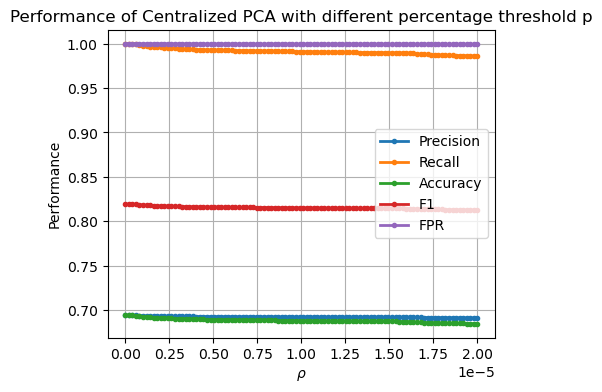

In [ ]:
plt.figure(figsize=(5, 4));
plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
plt.xlabel(r'$\rho$')
plt.ylabel('Performance')
# plt.xticks(xticks)
# plt.legend(loc = 'lower right')
plt.legend()
plt.grid()
plt.title("Performance of Centralized PCA with different percentage threshold p")
# plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
plt.show()

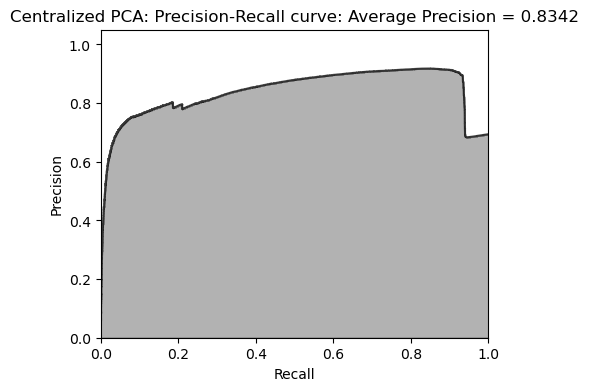

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])
average_precision = average_precision_score(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])

plt.figure(figsize=(5, 4));
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Centralized PCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
plt.show()

In [ ]:
precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=0.000001, log=1)

Precision: 69.3455%
Recall: 99.7993%
Accuracy score: 69.2494%
F1 score: 81.8308%
False alarm: 99.995%


### Standalone  PCA

In [ ]:
df_test_raw = df_test.copy()
df_normal_train = df_train.copy()
num_users = 100
fraction  = int(df_normal_train.shape[0] / num_users)
fraction, df_test_raw.shape

(560, (65332, 39))

In [ ]:
df_normal_train = df_normal_train.sort_values(by=['ct_srv_src'])
df_normal_train = df_normal_train.reset_index(drop=True)
df_normal_train

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,1,1,1,1,0,0,0,1,1,0
1,1.076050,14,18,1684,10168,28.809069,31,29,1.162771e+04,71401.882810,...,4,1,1,1,0,0,1,2,3,0
2,1.005373,12,18,1580,10168,28.845016,31,29,1.153005e+04,76421.390630,...,3,1,1,1,0,0,1,1,2,0
3,0.001097,2,2,130,162,2734.731157,31,29,4.740201e+05,590701.937500,...,7,1,1,2,0,0,0,6,2,0
4,2.415148,52,54,2934,3742,43.475596,31,29,9.533163e+03,12166.541990,...,2,1,1,4,1,1,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,0.000010,2,0,1422,0,100000.002500,254,0,5.688000e+08,0.000000,...,9,9,1,63,0,0,0,9,62,0
55996,0.000009,2,0,452,0,111111.107200,254,0,2.008889e+08,0.000000,...,4,4,1,63,0,0,0,4,62,0
55997,0.000011,2,0,2158,0,90909.090200,254,0,7.847273e+08,0.000000,...,4,4,1,63,0,0,0,4,62,0
55998,0.000010,2,0,570,0,100000.002500,254,0,2.280000e+08,0.000000,...,6,6,1,63,0,0,0,6,62,0


In [ ]:
#df_normal_train = df_train.copy()
avg_acc = 0
for i in range(100):
  df_train_stdPCA = df_normal_train[fraction*i:fraction*(i+1)].copy()
  df_train_client = df_train_stdPCA.copy()
  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train_client)
  df_test = pd.DataFrame(scaler.transform(df_test_raw))
  df_test.columns = df_test_abnormal.columns
  # Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train_client)
  _, df_test_PCA_inverse = perform_pca(df_train_client, df_test)

  abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

  df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
  df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score_PCA['anomalyScore'] = abnormal_score
  # plot_results(df_gt_score_PCA)

  # choose the right threshold
  lst_p = np.arange(0.4,0.8,0.001) # Among test, ratio of normal/abnormal = 0.75
  lst_rho = np.quantile(df_gt_score_PCA.anomalyScore, lst_p)
  optimal_p = 0.5
  optimal_rho = lst_rho[abs(lst_p - optimal_p)<1e-4][0]

  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=optimal_rho, log=1)
  avg_acc += accuracy_score
print(f"Average Accuracy: {100.0*avg_acc/100}")

/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 92.5628%
Recall: 66.688%
Accuracy score: 73.1678%
F1 score: 77.5233%
False alarm: 12.145%
(19, 39)
Precision: 92.5637%
Recall: 66.6968%
Accuracy score: 73.1739%
F1 score: 77.5296%
False alarm: 12.145%
(21, 39)
Precision: 92.841%
Recall: 66.8843%
Accuracy score: 73.4433%
F1 score: 77.7536%
False alarm: 11.69%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 91.7762%
Recall: 66.099%
Accuracy score: 72.3673%
F1 score: 76.8495%
False alarm: 13.425%
(20, 39)
Precision: 92.5502%
Recall: 66.6483%
Accuracy score: 73.1357%
F1 score: 77.4921%
False alarm: 12.16%
(24, 39)
Precision: 91.3734%
Recall: 65.8211%
Accuracy score: 71.9724%
F1 score: 76.5204%
False alarm: 14.085%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.4834%
Recall: 55.0781%
Accuracy score: 57.0792%
F1 score: 64.0394%
False alarm: 38.385%
(25, 39)
Precision: 76.2712%
Recall: 54.959%
Accuracy score: 56.8833%
F1 score: 63.8845%
False alarm: 38.755%
(25, 39)
Precision: 77.4597%
Recall: 55.8171%
Accuracy score: 58.0726%
F1 score: 64.8812%
False alarm: 36.815%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(20, 39)
Precision: 90.8572%
Recall: 65.349%
Accuracy score: 71.3938%
F1 score: 76.0204%
False alarm: 14.905%
(22, 39)
Precision: 92.7388%
Recall: 66.8005%
Accuracy score: 73.3347%
F1 score: 77.6611%
False alarm: 11.855%
(22, 39)
Precision: 92.5544%
Recall: 66.6615%
Accuracy score: 73.1464%
F1 score: 77.5025%
False alarm: 12.155%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 91.7646%
Recall: 66.1211%
Accuracy score: 72.3749%
F1 score: 76.8604%
False alarm: 13.45%
(24, 39)
Precision: 92.5553%
Recall: 66.6703%
Accuracy score: 73.1525%
F1 score: 77.5088%
False alarm: 12.155%
(22, 39)
Precision: 92.5383%
Recall: 66.6703%
Accuracy score: 73.1433%
F1 score: 77.5028%
False alarm: 12.185%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.2708%
Recall: 54.9435%
Accuracy score: 56.8757%
F1 score: 63.8739%
False alarm: 38.745%
(25, 39)
Precision: 76.2611%
Recall: 54.9281%
Accuracy score: 56.8619%
F1 score: 63.8601%
False alarm: 38.755%
(21, 39)
Precision: 76.2752%
Recall: 54.9568%
Accuracy score: 56.8848%
F1 score: 63.8844%
False alarm: 38.745%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 91.7573%
Recall: 66.0814%
Accuracy score: 72.3459%
F1 score: 76.8309%
False alarm: 13.455%
(21, 39)
Precision: 90.5808%
Recall: 65.2321%
Accuracy score: 71.1688%
F1 score: 75.8445%
False alarm: 15.375%
(20, 39)
Precision: 92.6037%
Recall: 66.7277%
Accuracy score: 73.2153%
F1 score: 77.5645%
False alarm: 12.08%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 76.0202%
Recall: 54.7781%
Accuracy score: 56.6323%
F1 score: 63.6742%
False alarm: 39.165%
(25, 39)
Precision: 92.5612%
Recall: 66.6725%
Accuracy score: 73.1571%
F1 score: 77.5123%
False alarm: 12.145%
(23, 39)
Precision: 77.4659%
Recall: 55.8215%
Accuracy score: 58.0787%
F1 score: 64.8863%
False alarm: 36.805%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(25, 39)
Precision: 78.2472%
Recall: 56.3465%
Accuracy score: 58.841%
F1 score: 65.515%
False alarm: 35.505%
(24, 39)
Precision: 92.5538%
Recall: 66.6836%
Accuracy score: 73.1602%
F1 score: 77.5172%
False alarm: 12.16%
(22, 39)
Precision: 82.0915%
Recall: 59.1547%
Accuracy score: 62.7043%
F1 score: 68.7607%
False alarm: 29.25%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 91.348%
Recall: 65.8188%
Accuracy score: 71.9571%
F1 score: 76.51%
False alarm: 14.13%
(26, 39)
Precision: 91.3607%
Recall: 65.8078%
Accuracy score: 71.9571%
F1 score: 76.507%
False alarm: 14.105%
(23, 39)
Precision: 77.0668%
Recall: 55.5016%
Accuracy score: 57.6639%
F1 score: 64.5302%
False alarm: 37.435%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 91.6914%
Recall: 66.0703%
Accuracy score: 72.303%
F1 score: 76.8004%
False alarm: 13.57%
(22, 39)
Precision: 75.9864%
Recall: 54.7185%
Accuracy score: 56.5818%
F1 score: 63.6221%
False alarm: 39.195%
(23, 39)
Precision: 92.5696%
Recall: 66.699%
Accuracy score: 73.1785%
F1 score: 77.5332%
False alarm: 12.135%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.2835%
Recall: 54.9678%
Accuracy score: 56.8955%
F1 score: 63.8948%
False alarm: 38.735%
(26, 39)
Precision: 92.7458%
Recall: 66.8137%
Accuracy score: 73.3469%
F1 score: 77.6725%
False alarm: 11.845%
(24, 39)
Precision: 91.3796%
Recall: 65.8255%
Accuracy score: 71.9785%
F1 score: 76.5256%
False alarm: 14.075%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 76.2636%
Recall: 54.9215%
Accuracy score: 56.8603%
F1 score: 63.8565%
False alarm: 38.745%
(23, 39)
Precision: 92.5637%
Recall: 66.6968%
Accuracy score: 73.1739%
F1 score: 77.5296%
False alarm: 12.145%
(24, 39)
Precision: 78.2764%
Recall: 56.4039%
Accuracy score: 58.8884%
F1 score: 65.5641%
False alarm: 35.48%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 92.1711%
Recall: 66.4078%
Accuracy score: 72.7775%
F1 score: 77.1967%
False alarm: 12.785%
(23, 39)
Precision: 92.5663%
Recall: 66.6946%
Accuracy score: 73.1739%
F1 score: 77.529%
False alarm: 12.14%
(23, 39)
Precision: 90.5643%
Recall: 65.2122%
Accuracy score: 71.1474%
F1 score: 75.8253%
False alarm: 15.4%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 90.566%
Recall: 65.2254%
Accuracy score: 71.1566%
F1 score: 75.8348%
False alarm: 15.4%
(22, 39)
Precision: 90.5672%
Recall: 65.2343%
Accuracy score: 71.1627%
F1 score: 75.8412%
False alarm: 15.4%
(25, 39)
Precision: 76.5352%
Recall: 55.1509%
Accuracy score: 57.1481%
F1 score: 64.1068%
False alarm: 38.325%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 77.4652%
Recall: 55.8193%
Accuracy score: 58.0772%
F1 score: 64.8845%
False alarm: 36.805%
(22, 39)
Precision: 78.2358%
Recall: 56.309%
Accuracy score: 58.815%
F1 score: 65.4857%
False alarm: 35.505%
(22, 39)
Precision: 90.5497%
Recall: 65.2277%
Accuracy score: 71.1489%
F1 score: 75.8306%
False alarm: 15.43%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 78.2459%
Recall: 56.3267%
Accuracy score: 58.8303%
F1 score: 65.5012%
False alarm: 35.495%
(25, 39)
Precision: 92.1856%
Recall: 66.2556%
Accuracy score: 72.6887%
F1 score: 77.0988%
False alarm: 12.73%
(26, 39)
Precision: 92.5608%
Recall: 66.6968%
Accuracy score: 73.1724%
F1 score: 77.5286%
False alarm: 12.15%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 78.3101%
Recall: 56.4281%
Accuracy score: 58.9221%
F1 score: 65.5923%
False alarm: 35.425%
(25, 39)
Precision: 92.0178%
Recall: 66.2953%
Accuracy score: 72.6229%
F1 score: 77.0669%
False alarm: 13.035%
(24, 39)
Precision: 78.2775%
Recall: 56.3995%
Accuracy score: 58.8869%
F1 score: 65.5615%
False alarm: 35.475%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 90.553%
Recall: 65.2321%
Accuracy score: 71.1535%
F1 score: 75.8347%
False alarm: 15.425%
(25, 39)
Precision: 90.5651%
Recall: 65.2607%
Accuracy score: 71.178%
F1 score: 75.8584%
False alarm: 15.41%
(22, 39)
Precision: 78.2513%
Recall: 56.3443%
Accuracy score: 58.8425%
F1 score: 65.515%
False alarm: 35.495%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 92.5514%
Recall: 66.688%
Accuracy score: 73.1617%
F1 score: 77.5194%
False alarm: 12.165%
(24, 39)
Precision: 78.2406%
Recall: 56.309%
Accuracy score: 58.818%
F1 score: 65.4874%
False alarm: 35.495%
(23, 39)
Precision: 78.2751%
Recall: 56.3995%
Accuracy score: 58.8854%
F1 score: 65.5606%
False alarm: 35.48%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 76.0638%
Recall: 54.8112%
Accuracy score: 56.6767%
F1 score: 63.7119%
False alarm: 39.095%
(25, 39)
Precision: 77.4677%
Recall: 55.7818%
Accuracy score: 58.0604%
F1 score: 64.8601%
False alarm: 36.775%
(23, 39)
Precision: 90.5642%
Recall: 65.2541%
Accuracy score: 71.1734%
F1 score: 75.8536%
False alarm: 15.41%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 92.5606%
Recall: 66.6946%
Accuracy score: 73.1709%
F1 score: 77.5271%
False alarm: 12.15%
(25, 39)
Precision: 92.5469%
Recall: 66.5623%
Accuracy score: 73.079%
F1 score: 77.4328%
False alarm: 12.15%
(25, 39)
Precision: 92.542%
Recall: 66.6792%
Accuracy score: 73.151%
F1 score: 77.5101%
False alarm: 12.18%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 92.5555%
Recall: 66.6725%
Accuracy score: 73.154%
F1 score: 77.5104%
False alarm: 12.155%
(24, 39)
Precision: 92.8331%
Recall: 66.8909%
Accuracy score: 73.4433%
F1 score: 77.7553%
False alarm: 11.705%
(24, 39)
Precision: 76.3048%
Recall: 54.9546%
Accuracy score: 56.9032%
F1 score: 63.8933%
False alarm: 38.68%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(26, 39)
Precision: 92.5579%
Recall: 66.6681%
Accuracy score: 73.1525%
F1 score: 77.5082%
False alarm: 12.15%
(26, 39)
Precision: 91.6577%
Recall: 66.0461%
Accuracy score: 72.2693%
F1 score: 76.7722%
False alarm: 13.625%
(25, 39)
Precision: 90.5697%
Recall: 65.2321%
Accuracy score: 71.1627%
F1 score: 75.8406%
False alarm: 15.395%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 76.2244%
Recall: 54.831%
Accuracy score: 56.7915%
F1 score: 63.7816%
False alarm: 38.765%
(18, 39)
Precision: 76.0292%
Recall: 54.7141%
Accuracy score: 56.6078%
F1 score: 63.6341%
False alarm: 39.1%
(18, 39)
Precision: 92.7902%
Recall: 66.8601%
Accuracy score: 73.4005%
F1 score: 77.7194%
False alarm: 11.775%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(21, 39)
Precision: 78.2646%
Recall: 56.3884%
Accuracy score: 58.8731%
F1 score: 65.5495%
False alarm: 35.495%
(24, 39)
Precision: 77.4689%
Recall: 55.8237%
Accuracy score: 58.0818%
F1 score: 64.8888%
False alarm: 36.8%
(21, 39)
Precision: 91.3638%
Recall: 65.8343%
Accuracy score: 71.9754%
F1 score: 76.526%
False alarm: 14.105%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 92.5613%
Recall: 66.6461%
Accuracy score: 73.1403%
F1 score: 77.4945%
False alarm: 12.14%
(22, 39)
Precision: 92.8934%
Recall: 66.9262%
Accuracy score: 73.4984%
F1 score: 77.8003%
False alarm: 11.605%
(24, 39)
Precision: 76.0842%
Recall: 54.8023%
Accuracy score: 56.6859%
F1 score: 63.7131%
False alarm: 39.045%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(22, 39)
Precision: 92.5488%
Recall: 66.6902%
Accuracy score: 73.1617%
F1 score: 77.5199%
False alarm: 12.17%
(23, 39)
Precision: 76.2933%
Recall: 54.9479%
Accuracy score: 56.8925%
F1 score: 63.8848%
False alarm: 38.7%
(22, 39)
Precision: 78.2686%
Recall: 56.362%
Accuracy score: 58.8624%
F1 score: 65.533%
False alarm: 35.47%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 90.551%
Recall: 65.2166%
Accuracy score: 71.1428%
F1 score: 75.8236%
False alarm: 15.425%
(21, 39)
Precision: 90.5645%
Recall: 65.2563%
Accuracy score: 71.1749%
F1 score: 75.8552%
False alarm: 15.41%
(20, 39)
Precision: 92.5853%
Recall: 66.7145%
Accuracy score: 73.1969%
F1 score: 77.5491%
False alarm: 12.11%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 90.5582%
Recall: 65.2078%
Accuracy score: 71.1412%
F1 score: 75.8201%
False alarm: 15.41%
(21, 39)
Precision: 90.5622%
Recall: 65.2387%
Accuracy score: 71.1627%
F1 score: 75.8424%
False alarm: 15.41%
(22, 39)
Precision: 76.1007%
Recall: 54.831%
Accuracy score: 56.7103%
F1 score: 63.7382%
False alarm: 39.03%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 92.0218%
Recall: 66.3064%
Accuracy score: 72.6321%
F1 score: 77.0757%
False alarm: 13.03%
(22, 39)
Precision: 92.5876%
Recall: 66.6814%
Accuracy score: 73.177%
F1 score: 77.5276%
False alarm: 12.1%
(24, 39)
Precision: 90.5679%
Recall: 65.2607%
Accuracy score: 71.1795%
F1 score: 75.8593%
False alarm: 15.405%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(24, 39)
Precision: 81.5496%
Recall: 58.7642%
Accuracy score: 62.1625%
F1 score: 68.3069%
False alarm: 30.135%
(22, 39)
Precision: 91.6756%
Recall: 66.0549%
Accuracy score: 72.2846%
F1 score: 76.7844%
False alarm: 13.595%
(24, 39)
Precision: 91.6024%
Recall: 66.0041%
Accuracy score: 72.2127%
F1 score: 76.7244%
False alarm: 13.715%


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(23, 39)
Precision: 90.564%
Recall: 65.2519%
Accuracy score: 71.1719%
F1 score: 75.852%
False alarm: 15.41%
(22, 39)
Precision: 76.2774%
Recall: 54.9634%
Accuracy score: 56.8894%
F1 score: 63.8896%
False alarm: 38.745%
(14, 39)
Precision: 78.2658%
Recall: 56.3686%
Accuracy score: 58.864%
F1 score: 65.5365%
False alarm: 35.48%
(12, 39)
Precision: 76.5729%
Recall: 55.1729%
Accuracy score: 57.1833%
F1 score: 64.1349%
False alarm: 38.26%
Average Accuracy: 66.77975570930019


/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
